<a href="https://colab.research.google.com/github/GhofranAlQArni/3DOF-Michanics/blob/main/Emotion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q tensorflow

# Import necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:

import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Dataset downloaded to:", path)



Dataset downloaded to: /kaggle/input/fer2013


In [12]:
# Define dataset directory paths
dataset_path = "/kaggle/input/fer2013"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

In [13]:
# Define Data Augmentation with mild transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators without 'workers' (Handled by Keras automatically)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# Compute class weights to handle imbalanced dataset
train_classes = np.array(train_generator.classes)
class_labels = np.unique(train_classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_classes)
class_weights = np.clip(class_weights, 0.5, 2.0)  # Lower max cap to 2.0 to prevent extreme bias
class_weights_dict = dict(enumerate(class_weights))

print("Final Class Weights:", class_weights_dict)

Final Class Weights: {0: np.float64(1.0266046844269623), 1: np.float64(2.0), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [15]:
# Compute class weights to handle imbalanced dataset
train_classes = np.array(train_generator.classes)
class_labels = np.unique(train_classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_classes)
class_weights = np.clip(class_weights, 0.5, 2.0)  # Lower max cap to 2.0 to prevent extreme bias
class_weights_dict = dict(enumerate(class_weights))

print("Final Class Weights:", class_weights_dict)

Final Class Weights: {0: np.float64(1.0266046844269623), 1: np.float64(2.0), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [17]:
# Define optimizer with weight decay
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)

# Define the model architecture
model = Sequential([
    Input(shape=(48, 48, 1)), # Input layer matching the image size and grayscale mode
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax') # Output layer with 7 units for 7 emotion classes
])


# Compile model with label smoothing
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,255 (1.36 MB)

 Trainable params: 356,551 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [19]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 195s 425ms/step - accuracy: 0.1675 - loss: 2.3984 - val_accuracy: 0.1722 - val_loss: 2.0330 - learning_rate: 3.0000e-04
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 326ms/step - accuracy: 0.1990 - loss: 1.9351 - val_accuracy: 0.3249 - val_loss: 1.7778 - learning_rate: 3.0000e-04
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 326ms/step - accuracy: 0.2222 - loss: 1.7954 - val_accuracy: 0.3593 - val_loss: 1.7191 - learning_rate: 3.0000e-04
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 337ms/step - accuracy: 0.2507 - loss: 1.7030 - val_accuracy: 0.3837 - val_loss: 1.6711 - learning_rate: 3.0000e-04
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 332ms/step - accuracy: 0.2955 - loss: 1.6316 - val_accuracy: 0.3798 - val_loss: 1.6514 - learning_rate: 3.0000e-04
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 200s 328ms/step - accuracy: 0.3187 - loss: 1.5919 - val_accuracy: 0.4048 - val_loss: 1.6520 - learning_rate: 3.0000e-04
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 

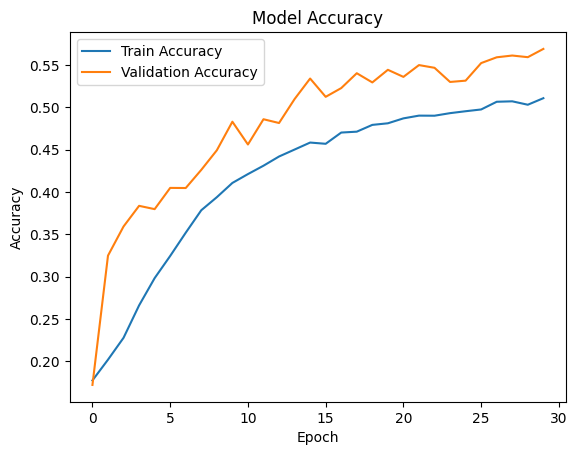

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [21]:
model.save('emotion_model.h5')

In [24]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

model = load_model('emotion_model.h5')

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    input_image = resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(input_image)
    emotion_index = np.argmax(prediction)
    return emotion_labels[emotion_index]



In [25]:
from google.colab import files
uploaded = files.upload()


Saving Emo-model.jpg to Emo-model.jpg


In [26]:
predict_emotion("Emo-model.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


'Happy'